# Fake Message Detection in Social Network using Deep Learning
## Social Network Analysis
### By - Hariharan J 22MCB1006 and Karthikheyan S 22MCS1006

## 1. Packages

In [1]:
import json
import os
import networkx as nx
from networkx.readwrite import json_graph
from util import constants
from util.util import tweet_node
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## 2. Pre-Processing

### Helper Functions to load the dataset

In [3]:
def construct_tweet_node_from_json(json_data):
    new_graph = json_graph.tree_graph(json_data)
    root_node = [node for node, in_degree in nx.DiGraph.in_degree(new_graph).items() if in_degree == 0][0]
    node_id_obj_dict = dict()
    dfs_node_construction_helper(root_node, new_graph, set(), node_id_obj_dict)
    return node_id_obj_dict[root_node]


def dfs_node_construction_helper(node_id, graph: nx.DiGraph, visited: set, node_id_obj_dict: dict):
    if node_id in visited:
        return None

    visited.add(node_id)

    tweet_node_obj = construct_tweet_node_from_nx_node(node_id, graph)

    node_id_obj_dict[node_id] = tweet_node_obj

    for neighbor_node_id in graph.successors(node_id):
        if neighbor_node_id not in visited:
            dfs_node_construction_helper(neighbor_node_id, graph, visited, node_id_obj_dict)
            add_node_object_edge(node_id, neighbor_node_id, node_id_obj_dict)


def add_node_object_edge(parent_node_id: int, child_node_id: int, node_id_obj_dict: dict):
    parent_node = node_id_obj_dict[parent_node_id]
    child_node = node_id_obj_dict[child_node_id]

    if child_node.node_type == constants.RETWEET_NODE:
        parent_node.add_retweet_child(child_node)
    elif child_node.node_type == constants.REPLY_NODE:
        parent_node.add_reply_child(child_node)
    else:
        # news node add both retweet and reply edge
        parent_node.add_retweet_child(child_node)
        parent_node.add_reply_child(child_node)


def construct_tweet_node_from_nx_node(node_id, graph: nx.DiGraph):
    return tweet_node(tweet_id=graph.node[node_id]['tweet_id'],
                      created_time=graph.node[node_id]['time'],
                      node_type=graph.node[node_id]['type'],
                      user_id=graph.node[node_id]['user'],
                      botometer_score=graph.node[node_id].get('bot_score', None),
                      sentiment=graph.node[node_id].get('sentiment', None))

def load_networkx_graphs(dataset_dir: str, news_source: str, news_label: str):
    news_dataset_dir = "{}/{}_{}".format(dataset_dir, news_source, news_label)

    news_samples = []

    for news_file in os.listdir(news_dataset_dir):
        with open("{}/{}".format(news_dataset_dir, news_file)) as file:
            news_samples.append(json_graph.tree_graph(json.load(file)))

    return news_samples


def load_dataset(dataset_dir: str, news_source: str):
    fake_news_samples = load_networkx_graphs(dataset_dir, news_source, "fake")
    real_news_samples = load_networkx_graphs(dataset_dir, news_source, "real")

    return fake_news_samples, real_news_samples

### Loading fake and real networks

In [4]:
fake_samples, real_samples = load_dataset("./Datasets/nx_network_data", "politifact")

In [5]:
X = [nx.adjacency_matrix(graph).toarray() for graph in fake_samples]
Y = [0 for graph in fake_samples]

X.extend([nx.adjacency_matrix(graph).toarray() for graph in real_samples])
Y.extend([1 for graph in real_samples])

print("Shape : ", len(X), len(Y))

Shape :  628 628


### Removing Graphs with Nodex > 1000 due to computational constraints

In [6]:
indexs = [index for index in range(len(X)) if len(X[index]) > 1000]
print("No of Indexes to be removed : ", len(indexs))
print("Indexes to be removed : ", indexs)

No of Indexes to be removed :  158
Indexes to be removed :  [8, 12, 14, 16, 22, 23, 39, 42, 45, 50, 54, 57, 65, 71, 72, 80, 100, 102, 111, 114, 117, 121, 130, 134, 136, 141, 145, 150, 151, 155, 158, 162, 163, 165, 167, 168, 174, 176, 184, 186, 190, 195, 212, 218, 227, 228, 229, 232, 234, 239, 241, 250, 251, 255, 257, 268, 270, 273, 286, 295, 296, 298, 301, 304, 310, 311, 314, 325, 334, 335, 342, 343, 346, 353, 356, 358, 361, 362, 363, 364, 372, 381, 383, 384, 386, 388, 389, 391, 396, 397, 399, 401, 404, 405, 406, 408, 410, 412, 413, 417, 418, 422, 426, 432, 434, 437, 439, 441, 446, 450, 456, 457, 463, 465, 467, 470, 472, 474, 475, 482, 483, 496, 497, 503, 504, 505, 511, 520, 523, 525, 530, 535, 539, 541, 542, 548, 549, 566, 567, 568, 584, 585, 586, 588, 590, 591, 592, 595, 596, 604, 606, 607, 608, 614, 615, 616, 619, 621]


In [7]:
for i in sorted(indexs, reverse=True):
    del X[i]
    del Y[i]

In [8]:
avg_no_nodes = sum([adj_matrix.shape[0] for adj_matrix in X]) / len(X)
max_nodes = max([adj_matrix.shape[0] for adj_matrix in X])
print("Avg No of Nodes : ", avg_no_nodes)
print("Max No of Nodes : ", max_nodes)

Avg No of Nodes :  216.1404255319149
Max No of Nodes :  989


### Making the shape of adjacency matrix uniform

In [9]:
for j in range(len(X)):
    desired_shape = (max_nodes, max_nodes)
    pad_width = [(0, desired_shape[i] - X[j].shape[i]) for i in range(len(desired_shape))]
    padded_arr = np.pad(X[j], pad_width, mode='constant', constant_values=0)
    X[j] = padded_arr.copy()

In [10]:
avg_no_nodes = sum([adj_matrix.shape[0] for adj_matrix in X]) / len(X)
max_nodes = max([adj_matrix.shape[0] for adj_matrix in X])
print("Avg No of Nodes : ", avg_no_nodes)
print("Max No of Nodes : ", max_nodes)

Avg No of Nodes :  989.0
Max No of Nodes :  989


### 80-20 Train-Test split 

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1, shuffle=True)

In [12]:
print("Train")
no_of_fake_in_train = sum([1 for label in y_train if label == 0 ])
no_of_real_in_train = sum([1 for label in y_train if label == 1 ])
print("Fake : ", no_of_fake_in_train, " Real : ", no_of_real_in_train)

print("Test")
no_of_fake_in_test = sum([1 for label in y_test if label == 0 ])
no_of_real_in_test = sum([1 for label in y_test if label == 1 ])
print("Fake : ", no_of_fake_in_test, " Real : ", no_of_real_in_test)

Train
Fake :  224  Real :  152
Test
Fake :  54  Real :  40


## 3. MetaData


### Nodes

In [57]:
avg_no_nodes_fake = sum([len(fake_sample.nodes) for fake_sample in fake_samples]) / len(fake_samples)
avg_no_nodes_real = sum([len(real_sample.nodes) for real_sample in real_samples]) / len(real_samples)

max_nodes_fake = max([len(fake_sample.nodes) for fake_sample in fake_samples])
max_nodes_real = max([len(real_sample.nodes) for real_sample in real_samples])

print("Avg No of Nodes in Fake samples: ", avg_no_nodes_fake)
print("Avg No of Nodes in Real samples: ", avg_no_nodes_real)
print("Max No of Nodes in Fake : ", max_nodes_fake)
print("Max No of Nodes in Real : ", max_nodes_real)

Avg No of Nodes in Fake samples:  809.4814814814815
Avg No of Nodes in Real samples:  1517.0469314079423
Max No of Nodes in Fake :  39519
Max No of Nodes in Real :  32291


### Density

In [60]:
avg_den_nodes_fake = sum([nx.density(fake_sample) for fake_sample in fake_samples]) / len(fake_samples)
avg_den_nodes_real = sum([nx.density(real_sample) for real_sample in real_samples]) / len(real_samples)

print("Avg Density of Nodes in Fake samples: ", avg_den_nodes_fake)
print("Avg Density of Nodes in Real samples: ", avg_den_nodes_real)

Avg Density of Nodes in Fake samples:  0.0170438341787127
Avg Density of Nodes in Real samples:  0.0289003833007135


### Node Connectivity

In [ ]:
avg_node_connectivity_nodes_fake = sum([nx.average_node_connectivity(fake_sample) for fake_sample in fake_samples]) / len(fake_samples)
avg_node_connectivity_real = sum([nx.average_node_connectivity(real_sample) for real_sample in real_samples]) / len(real_samples)

print("Avg Connectivity of Nodes in Fake samples: ", avg_node_connectivity_nodes_fake)
print("Avg Connectivity of Nodes in Real samples: ", avg_node_connectivity_real)

## 4. Visualizing the Graphs

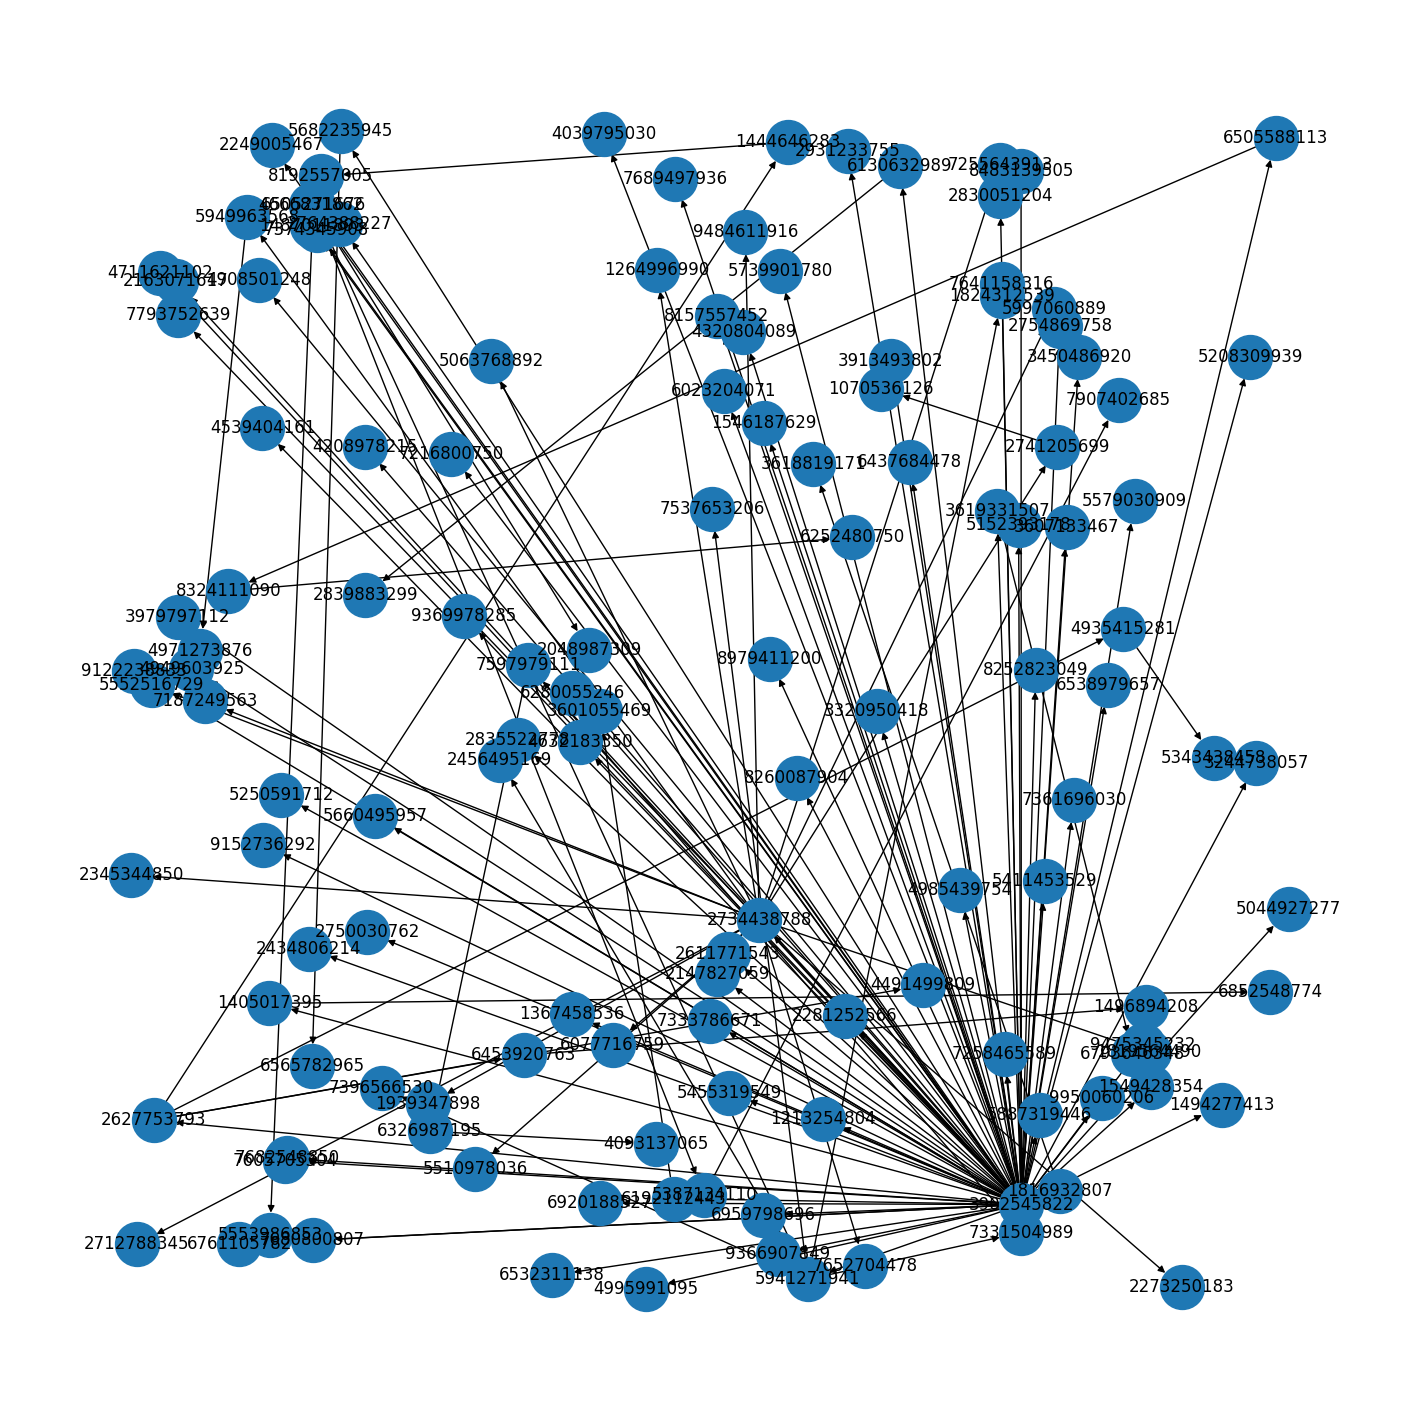

In [13]:
plt.figure(figsize=(14,14)) 
nx.draw(fake_samples[2],nx.random_layout(fake_samples[2]), with_labels=True, node_size=1000)
plt.show()

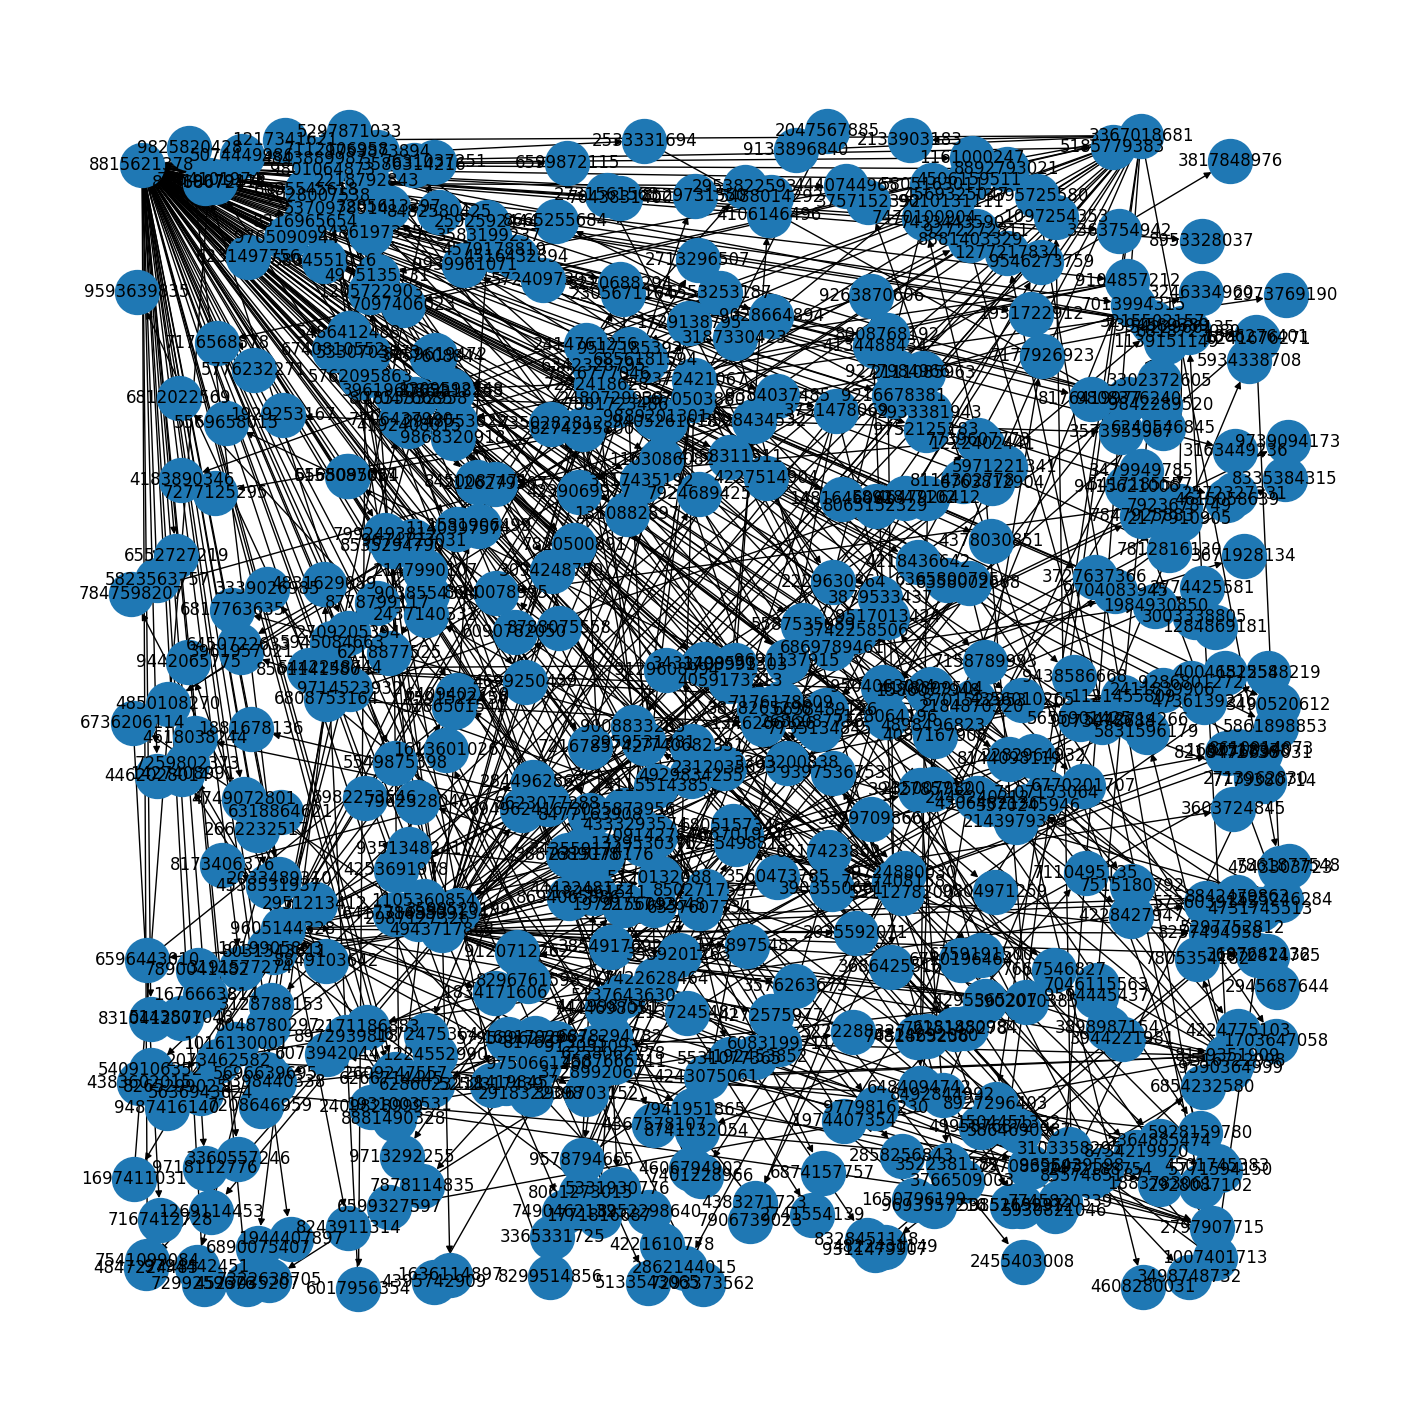

In [5]:
plt.figure(figsize=(14,14)) 
nx.draw(real_samples[0],nx.random_layout(real_samples[0]), with_labels=True, node_size=1000)
plt.show()

## 5. Classification

In [29]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.int32)

In [30]:
#Label encoding
def LabelEncoding(Y): 
    le = LabelEncoder()
    le.fit(Y)
    Y = le.transform(Y)
    return Y

y_train = LabelEncoding(y_train)

y_train = tf.one_hot(y_train, depth=2)

In [31]:
x_train

<tf.Tensor: shape=(376, 989, 989), dtype=int32, numpy=
array([[[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0,

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(max_nodes, max_nodes, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 987, 987, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 493, 493, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 491, 491, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 245, 245, 64)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 243, 243, 128)     73856     
                                                                 
 flatten_2 (Flatten)         (None, 7558272)          

In [33]:
model.fit(x_train, y_train, epochs=10, batch_size=3)

Epoch 1/10


2023-05-25 09:04:00.586871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 84s 645ms/step - loss: 0.7054 - accuracy: 0.5638
Epoch 2/10
126/126 [==============================] - 79s 627ms/step - loss: 0.6992 - accuracy: 0.5957
Epoch 3/10
126/126 [==============================] - 78s 620ms/step - loss: 0.6542 - accuracy: 0.5957
Epoch 4/10
126/126 [==============================] - 80s 636ms/step - loss: 0.6238 - accuracy: 0.6037
Epoch 5/10
126/126 [==============================] - 78s 620ms/step - loss: 0.5209 - accuracy: 0.6888
Epoch 6/10
126/126 [==============================] - 80s 633ms/step - loss: 0.4146 - accuracy: 0.7846
Epoch 7/10
126/126 [==============================] - 79s 629ms/step - loss: 0.3034 - accuracy: 0.8564
Epoch 8/10
126/126 [==============================] - 77s 612ms/step - loss: 0.2104 - accuracy: 0.9043
Epoch 9/10
126/126 [==============================] - 78s 618ms/step - loss: 0.1781 - accuracy: 0.9122
Epoch 10/10
126/126 [==============================] - 78s 619ms/step - loss: 0.2153

In [48]:
y_train_pred = model.predict(x_train)

12/12 [==============================] - 18s 2s/step


In [49]:
y_train_pred = np.argmax(y_train_pred, axis=1).tolist()

In [53]:
cm = confusion_matrix(np.argmax(y_train, axis=1).tolist(), y_train_pred)
acc = accuracy_score(np.argmax(y_train, axis=1).tolist(), y_train_pred)

In [54]:
print("Confusion Matrix : ")
print(cm)
print()
print("Accuracy : ")
print(acc)

Confusion Matrix : 
[[181  43]
 [  0 152]]

Accuracy : 
0.8856382978723404


In [55]:
classy_rep = classification_report(np.argmax(y_train, axis=1).tolist(), y_train_pred)
print(classy_rep)

              precision    recall  f1-score   support

           0       1.00      0.81      0.89       224
           1       0.78      1.00      0.88       152

    accuracy                           0.89       376
   macro avg       0.89      0.90      0.88       376
weighted avg       0.91      0.89      0.89       376



In [ ]:
import networkx as nx
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from karateclub import DeepWalk

# import dataset
df = pd.read_csv("/content/politician_edges.csv")
df.head()

# create Graph
G = real_samples[0]

# train model and generate embedding
model = DeepWalk(walk_length=100, dimensions=64, window_size=5)
model.fit(G)
embedding = model.get_embedding()

# print Embedding shape
print(embedding.shape)
# take first 100 nodes
nodes =list(range(100))

# plot nodes graph
def plot_nodes(node_no):
	X = embedding[node_no]
	
	pca = PCA(n_components=2)
	pca_out= pca.fit_transform(X)
	
	
	plt.figure(figsize=(15,10))
	plt.scatter(pca_out[:, 0], pca_out[:, 1])
	for i, node in enumerate(node_no):
		plt.annotate(node, (pca_out[i, 0], pca_out[i, 1]))
	plt.xlabel('Label_1')
	plt.ylabel('label_2')
	plt.show()

plot_nodes(nodes)
